In [224]:
import torch as tc
import huggingface_hub as hf
from datasets import load_dataset
import pandas as pd
import numpy as np
from huggingface_hub import list_datasets
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel

In [ ]:
# List datasets on the Hugging Face Hub
#datasets = list(list_datasets())
#print(len(datasets))

Cargamos la data "emotion"

In [57]:
emotions = load_dataset("emotion")

Podemos ver que consiste de 3 dataset: "train", "val" y "test".

In [58]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [59]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

Usando .features, podemos revisar que significa cada label:

In [60]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [61]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [62]:
train_ds["text"][:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

Las transformamos a un pands dataframe:

In [63]:
df_emotions = emotions["train"].to_pandas()

In [64]:
df_emotions.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [229]:
emotions["train"].features["label"]

ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)

In [71]:
emotions["train"].features["label"].int2str(1)

'joy'

Creamos una función para recuperar el label_name para todo row del dataframe:

In [ ]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df_emotions["label_name"] = df_emotions["label"].apply(label_int2str) #aplicamos la función a cada row
df_emotions.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Vemos como están distribuidos los labels

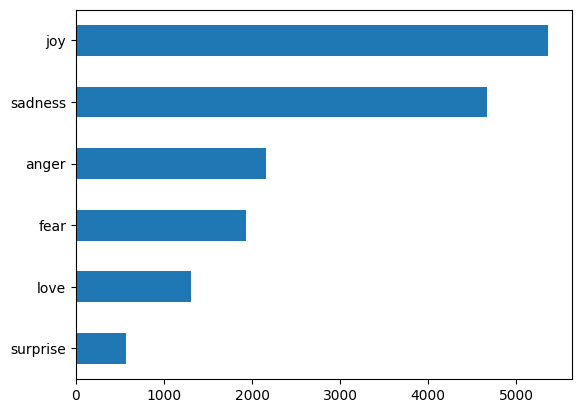

In [84]:
df_emotions["label_name"].value_counts(ascending = True).plot.barh();

Ahora empezaremos a estudiar sobre tokens. La primera forma (y mas bruta) es simplemente dividir un texto en sus caracteres:

In [89]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


Luego, mappeamos cada letra a un número:

In [92]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text))) }
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


Y después representamos el texto por los números:

In [93]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


Notemos que no es la mejor forma. Se pierden las palabras en sí, y el vector es demasiado largo.

Mappear cada palabra a un número tampoco es buena idea, pues los one hot vectores tendrán demasiadas dimensiones

In [94]:
categorical_df = pd.DataFrame(
        {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [97]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


In [ ]:
input_ids = tc.tensor(input_ids)
one_hot_encodings = tc.nn.functional.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

/var/folders/ys/w1pzn7n93576nfnymmmrx6wh0000gn/T/ipykernel_2747/2297724753.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = tc.tensor(input_ids)


torch.Size([38, 20])

In [106]:
input_ids

tensor([ 5, 14, 12,  8, 13, 11, 19, 11, 13, 10,  0, 17,  8, 18, 17,  0, 11, 16,
         0,  6,  0,  7, 14, 15,  8,  0, 17,  6, 16, 12,  0, 14,  9,  0,  3,  2,
         4,  1])

In [103]:
print(f"Token: {tokenized_text[0]}") 
print(f"Tensor index: {input_ids[0]}") 
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


Para tokenizar, usaremos el modelo "distilbert" pre-entrenado:

In [143]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Podemos notar que ciertas palabras las deja igual, mientras que otras las divide agregando el caracter ##. También agrega tokens señalando el comienzo y final de cada palabra.

In [ ]:
encoded_text = tokenizer(text)
print("text: ", text) #texto
print("tokenized text: ", encoded_text) #texto codificado. El input_ids nos entrega los tokens respectivos. Notemos que es un diccionario.
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids) #Usando el tokenizer, podemos pasar de los ids a los tokens.
print("tokens: ", tokens)   

text:  Tokenizing text is a core task of NLP.
tokenized text:  {'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
tokens:  ['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


Podemos recuperar el texto desde los tokens:

In [123]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [145]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True) #El padding es para agregar 0 si la frase es muy corta, y truncation para cortar si es muy larga. Así establecemos un tamaño homogeneo.

El attention mask nos dice que tokens debemos considerar

In [147]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Tokenizamos toda la data:

In [148]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map: 100%|██████████| 2000/2000 [00:00<00:00, 17336.74 examples/s]


In [151]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [ ]:
device = tc.device("cuda" if tc.cuda.is_available() else "cpu") #Si tenemos GPU, usa eso.
model = AutoModel.from_pretrained(model_ckpt).to(device) #Elegimos donde hacerlo dependiendo de lo anterior

In [192]:
test = "this is a text"

In [200]:
inputs = tokenizer(test, return_tensors="pt")
print(inputs)
print(f"Input tensor shape: {inputs['input_ids'].size()}")

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3793,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}
Input tensor shape: torch.Size([1, 6])


In [202]:
inputs = {k:v.to(device) for k,v in inputs.items()}
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3793,  102]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [211]:
print(inputs["input_ids"].shape)
print(inputs["input_ids"][0])

torch.Size([1, 6])
tensor([ 101, 2023, 2003, 1037, 3793,  102])


In [208]:
tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

['[CLS]', 'this', 'is', 'a', 'text', '[SEP]']

In [212]:
with tc.no_grad():
    outputs = model(**inputs) 
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.2535, -0.1091,  0.0759,  ..., -0.1054,  0.2257,  0.4615],
         [-0.7154, -0.2742, -0.0954,  ..., -0.3597,  0.5174,  0.3450],
         [-0.4100, -0.2195,  0.1850,  ..., -0.0136,  0.1607,  1.0422],
         [-0.2523, -0.0254,  0.2472,  ..., -0.1637,  0.0865,  1.0516],
         [-0.0570, -0.1057,  0.0662,  ...,  0.0584,  0.1034,  0.2971],
         [ 0.9184,  0.1577, -0.4105,  ...,  0.1509, -0.7327, -0.1572]]]), hidden_states=None, attentions=None)


In [180]:
print(outputs.last_hidden_state)
print(outputs.last_hidden_state.shape)

tensor([[[-0.2535, -0.1091,  0.0759,  ..., -0.1054,  0.2257,  0.4615],
         [-0.7154, -0.2742, -0.0954,  ..., -0.3597,  0.5174,  0.3450],
         [-0.4100, -0.2195,  0.1850,  ..., -0.0136,  0.1607,  1.0422],
         [-0.2523, -0.0254,  0.2472,  ..., -0.1637,  0.0865,  1.0516],
         [-0.0570, -0.1057,  0.0662,  ...,  0.0584,  0.1034,  0.2971],
         [ 0.9184,  0.1577, -0.4105,  ...,  0.1509, -0.7327, -0.1572]]])
torch.Size([1, 6, 768])


Thus, for each token in our input test, it returns a 768 vector.

In [213]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [215]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names} # Extract last hidden states
    with tc.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
        # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [217]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [218]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map: 100%|██████████| 2000/2000 [07:57<00:00,  4.19 examples/s]


In [223]:
print(emotions_hidden["train"]["text"][0])
print(emotions_hidden["train"]["hidden_state"][0])

i didnt feel humiliated
tensor([-1.1675e-01,  9.8571e-02, -1.2963e-01, -9.5018e-02, -2.8083e-01,
        -1.3222e-01,  2.2748e-01,  2.3100e-01,  1.6752e-01, -2.4663e-01,
         2.1755e-02, -1.0200e-01, -1.8098e-01,  2.2351e-01,  2.0275e-01,
         1.1693e-01, -6.9520e-04,  1.2025e-01, -1.4275e-04, -6.0743e-02,
        -1.4382e-01, -3.1201e-01, -1.0877e-01,  1.1821e-01, -7.3939e-02,
         7.2635e-02,  2.1319e-01, -2.9570e-01,  1.0432e-01, -1.4980e-01,
         1.1913e-01,  1.3559e-01, -2.0512e-01,  7.9982e-02, -1.2340e-01,
         2.4995e-02,  1.1948e-02,  1.0090e-02,  1.3740e-01, -1.3440e-02,
        -1.1266e-01, -7.7646e-02, -1.3007e-01, -7.1688e-02,  8.5298e-02,
        -5.4750e-02, -2.1881e+00, -5.0468e-02, -3.2211e-01, -1.6244e-01,
         3.1700e-01, -1.9576e-01,  1.3216e-01,  3.7076e-01, -5.4104e-02,
         3.5674e-01, -1.9445e-01,  3.1695e-01, -2.2347e-02,  9.1786e-02,
         2.9930e-01,  2.1970e-01, -1.4083e-01, -7.3253e-03, -7.7053e-02,
         2.2294e-01, -8.260

In [225]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape


((16000, 768), (2000, 768))